## Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from IPython.core.display import HTML
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
import random
import pickle

### Helper Function

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
 
    n = cm.sum()
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    

    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

In [3]:
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))

In [4]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

In [5]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )},
                          index=[0])

In [6]:
%matplotlib inline
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.set_option( 'display.expand_frame_repr', False )
sns.set()

### Load Data

In [7]:
df_sales_raw = pd.read_csv("Ross_data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("Ross_data/store.csv", low_memory=False)

### Merge Data

In [8]:
df_raw = pd.merge(df_sales_raw,df_store_raw, how = 'left', on='Store')

## Data Description

In [9]:
df1 = df_raw.copy()

### Rename Columns

In [10]:
old_cols = df1.columns.copy()
snakecase = lambda x: inflection.underscore(x)
df1.columns = list(map(snakecase,old_cols))

### Data Dimensions

In [11]:
print(f'The df has {df1.shape[0]} rows and {df1.shape[1]} columns')

The df has 1017209 rows and 18 columns


### Data types and NaN values

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Fillout NaN

In [14]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
#promo2_since_year       
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
#promo_interval
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0,inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

### Changing data types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### Descriptive Statistical

In [17]:
df_c = df1.select_dtypes(include = ['object'])
df_n = df1.select_dtypes(exclude = ['object','datetime64[ns]'])

#### Numerical attributes

In [18]:
# Central tendency
df_mean = df_n.apply(lambda x: np.mean(x)).T
df_median = df_n.apply(lambda x: np.median(x)).T

# Dispersion
df_std = df_n.apply(lambda x: np.std(x)).T
df_range = df_n.apply(lambda x: x.max() - x.min()).T
df_min = df_n.apply(lambda x: x.min()).T
df_max = df_n.apply(lambda x: x.max()).T
df_skew = df_n.apply(lambda x: x.skew()).T
df_kurtosis = df_n.apply(lambda x: x.kurtosis()).T

df_describe = pd.concat([df_mean,df_median,df_std,df_min,df_max,df_range,df_skew,df_kurtosis],axis = 1).reset_index()
df_describe.columns = ['attributes','mean','median','std','min','max','range','skew','kurtosis']
df_describe

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

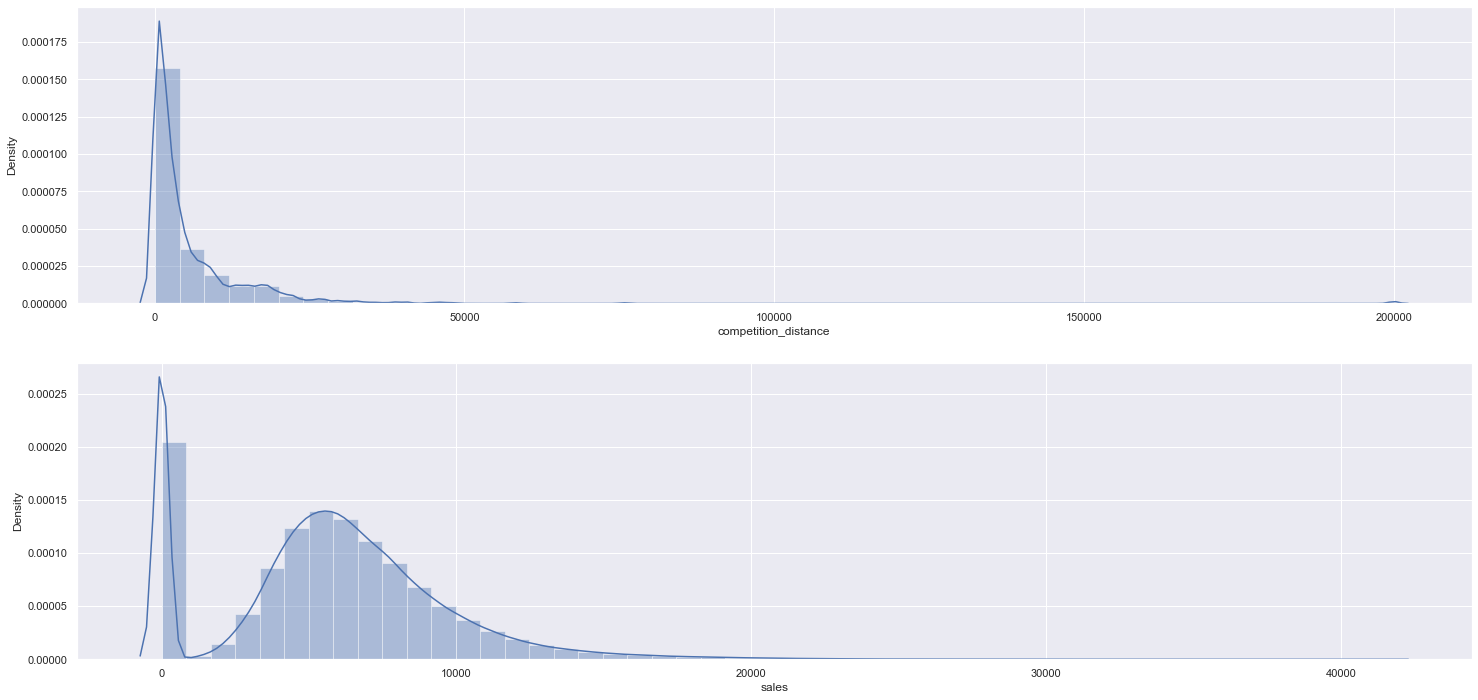

In [19]:
plt.subplot(2,1,1)
sns.distplot(df1['competition_distance'])
plt.subplot(2,1,2)
sns.distplot(df1['sales'])

#### Categorical attributes

In [20]:
# Unique values for each category
df_c.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

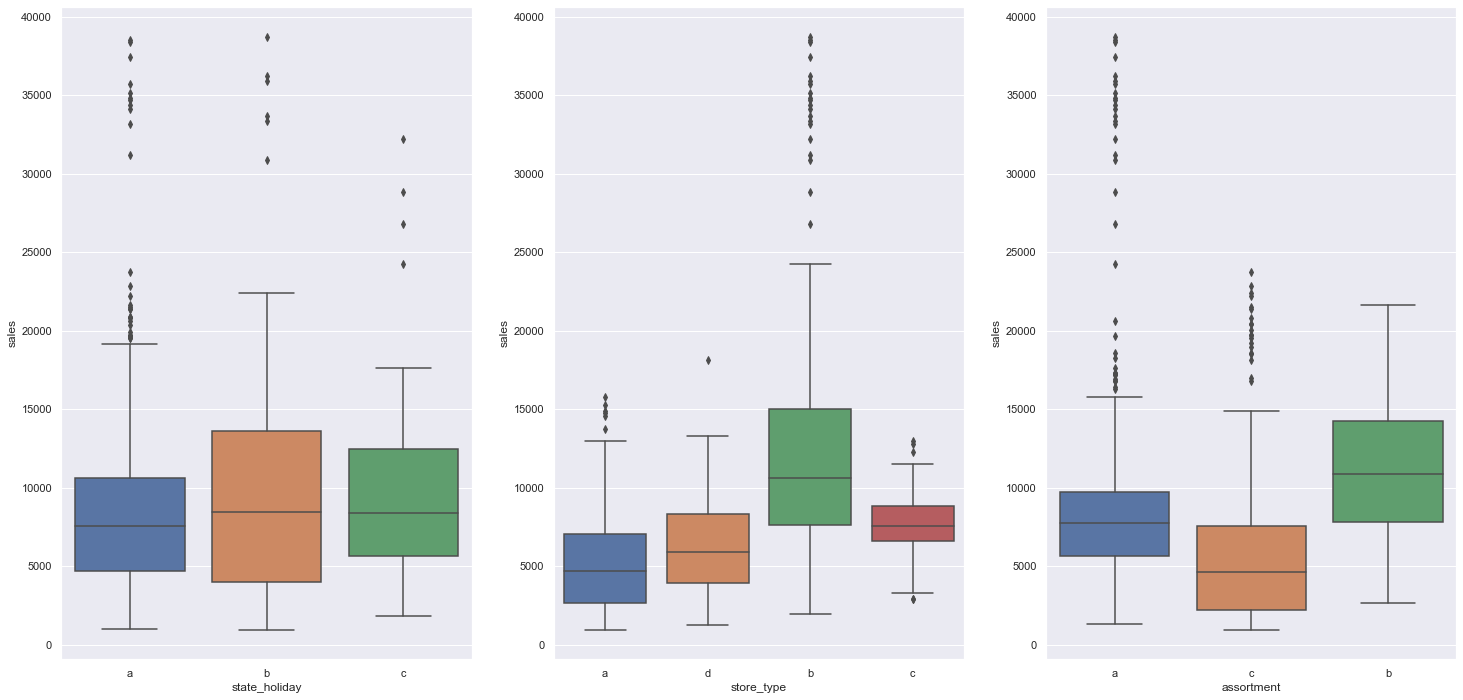

In [21]:
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y = 'sales', data = df1[(df1['state_holiday']!= '0') & (df1['sales']>0)])

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y = 'sales', data = df1[(df1['state_holiday']!= '0') & (df1['sales']>0)])

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y = 'sales', data = df1[(df1['state_holiday']!= '0') & (df1['sales']>0)])

## Feature Engineering

In [21]:
df2 = df1.copy()

### Creating hypothesis

#### Hypothesis store

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

#### Hypothesis client

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

#### Hypothesis date

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender menos.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

#### Chosen Hypothesis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender menos no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.
 
**12.** Lojas deveriam vender menos durante os feriados escolares.

### Feature Engineering

In [22]:
#Year
df2['year'] = df2['date'].dt.year
#Month
df2['month'] = df2['date'].dt.month
#Day
df2['day'] = df2['date'].dt.day
#Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear
#Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
#Competition Since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )
#Promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' +df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
#Assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
#State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/tmp/ipykernel_9634/2128729213.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


## Variable Filtering

In [23]:
df3 = df2.copy()

### Selecting rows

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales']>0)]

### Selecting columns

In [25]:
drop_cols = ['customers','open','promo_interval','month_map']
df3 = df3.drop(drop_cols, axis = 1)

## Exploratory Data Analysis

In [26]:
df4 = df3.copy()

### Univariate Analysis

#### Response Variable

/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

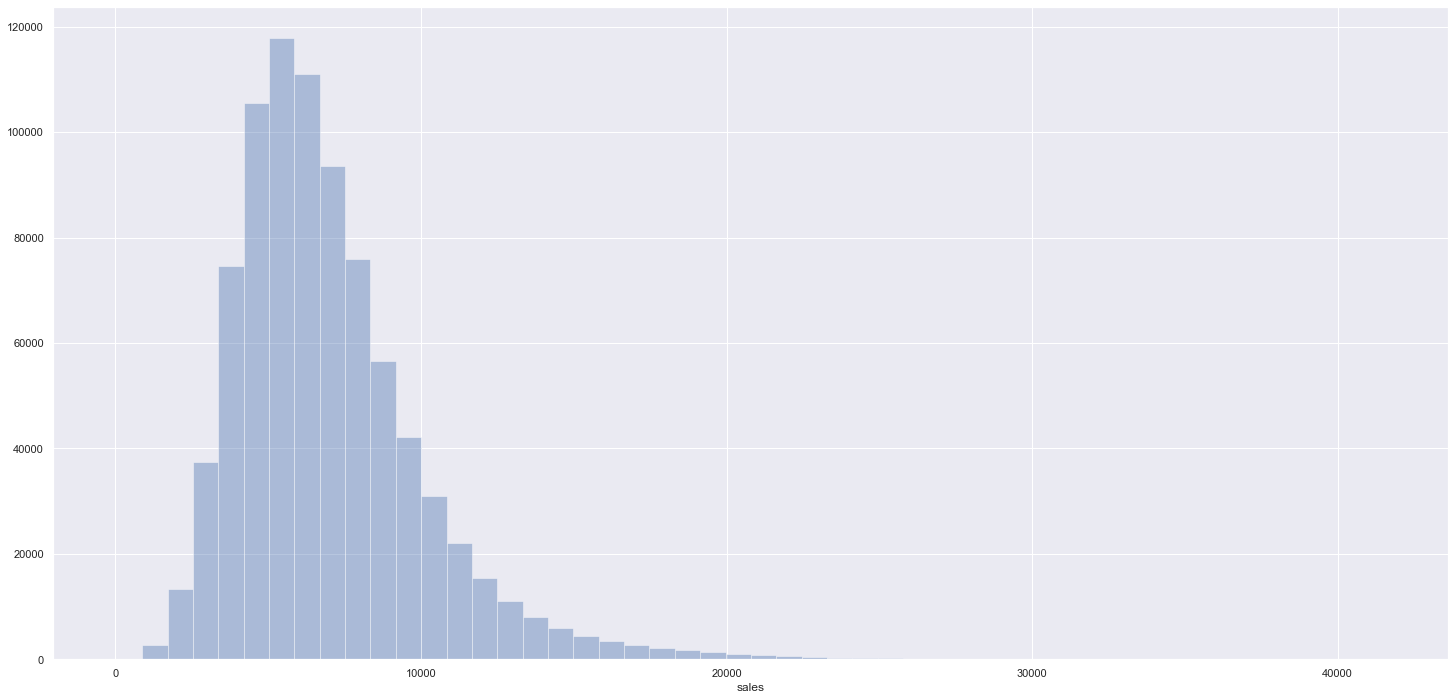

In [28]:
sns.distplot(df4['sales'], kde = False)

#### Numerical Variable

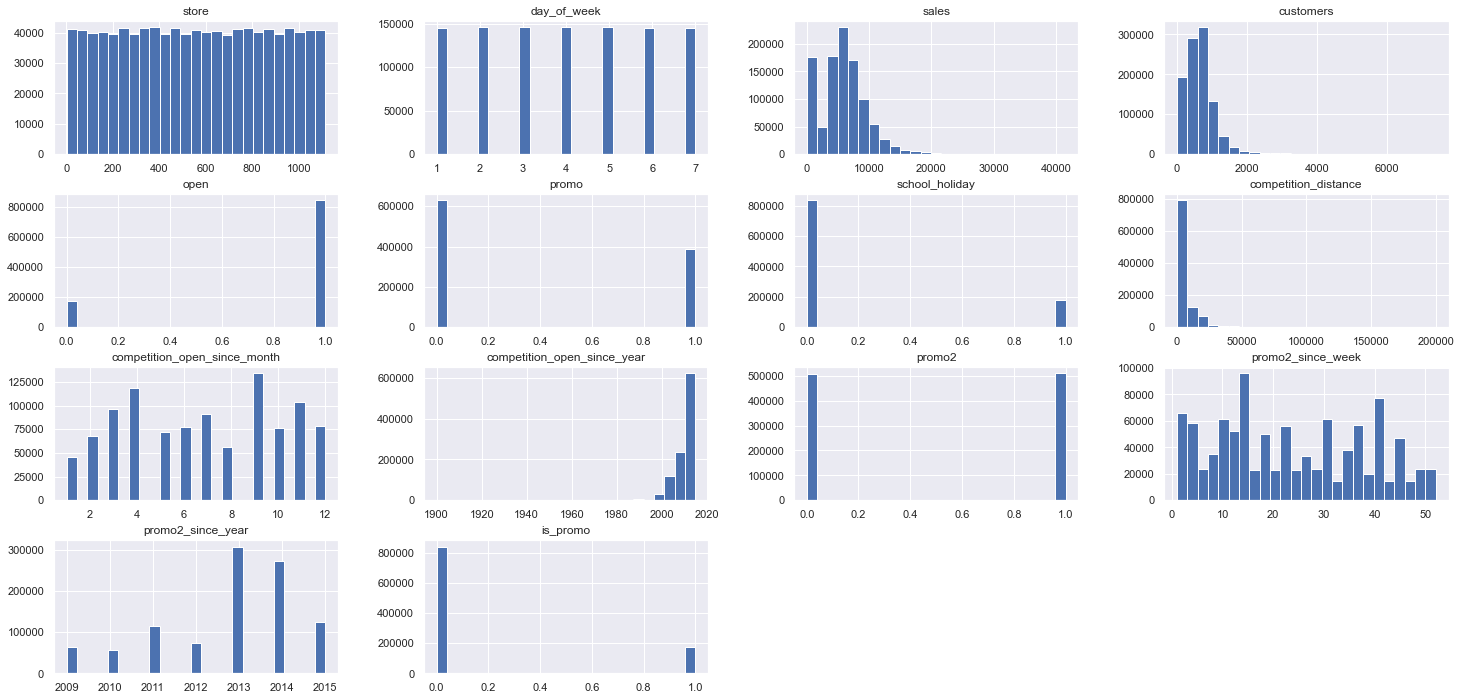

In [29]:
df_n.hist(bins = 25);

#### Categorical Variable

/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

<AxesSubplot:xlabel='sales', ylabel='Density'>

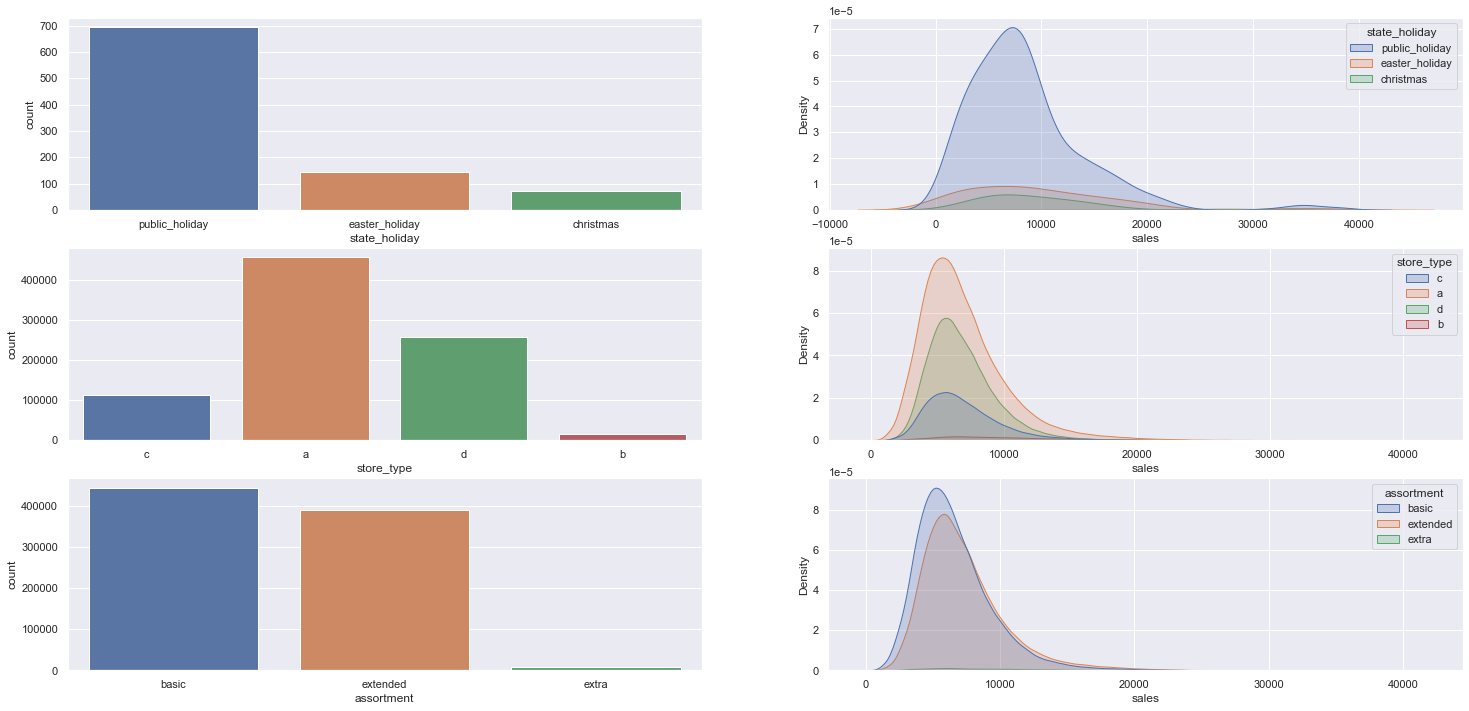

In [30]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(data = df4[df4['state_holiday'] != 'regular_day'], x = 'sales', shade = True, hue = 'state_holiday')

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(data = df4, x = 'sales', shade = True, hue = 'store_type')

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(data = df4, x = 'sales', shade = True, hue = 'assortment')

In [31]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

### Bivariate Analysis

#### **H1.** Lojas com maior sortimento deveriam vender mais.

***Falsa*** -  Lojas com maior sortimento vendem **MENOS**.

<AxesSubplot:xlabel='year_week'>

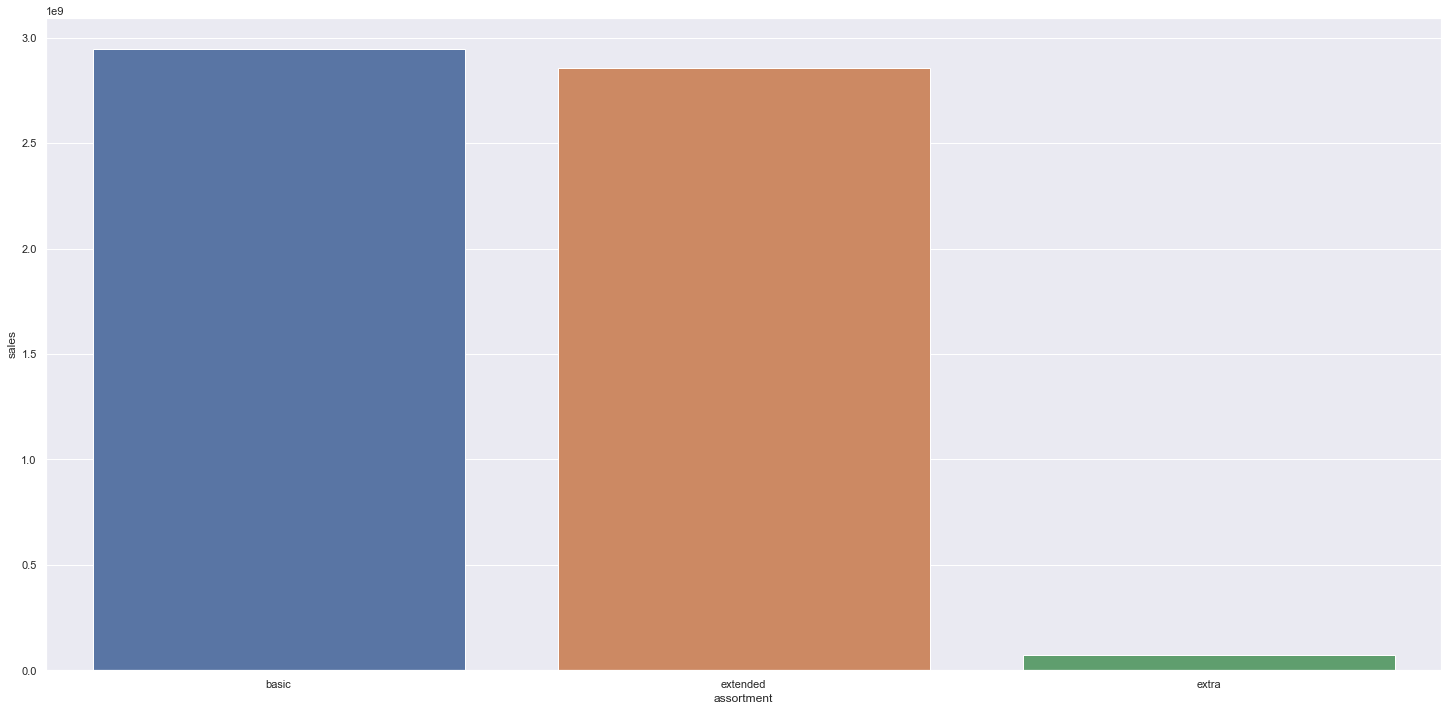

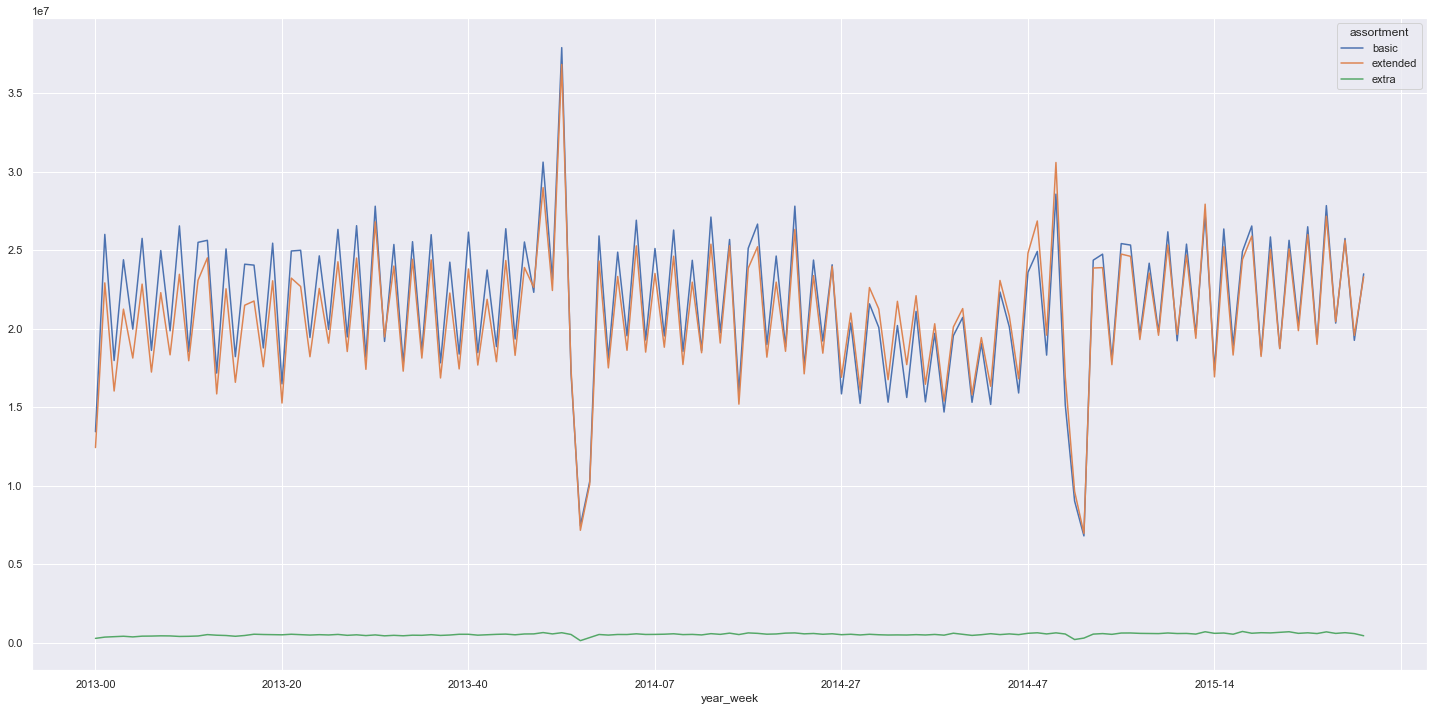

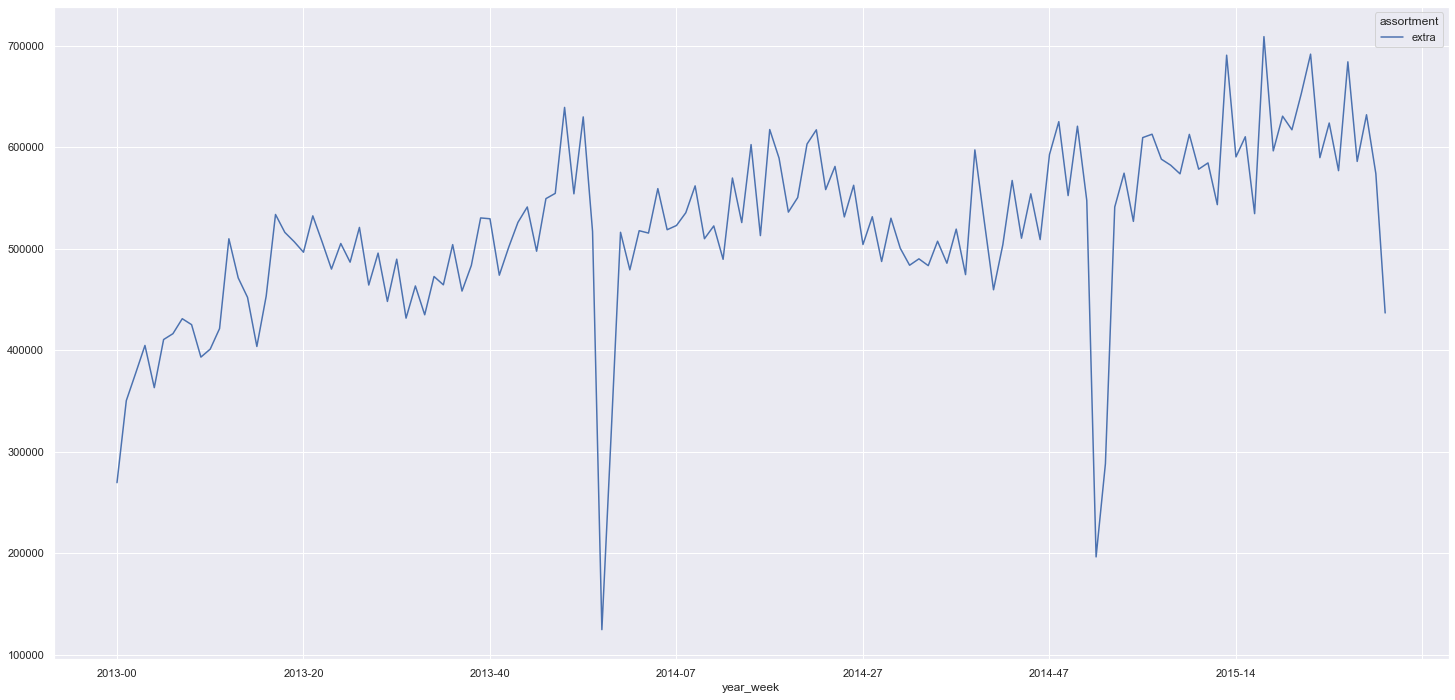

In [32]:
aux = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week',columns = 'assortment',values = 'sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns = 'assortment', values = 'sales').plot()

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.

***Falso*** - Lojas com competidores mais próximos vendem **MENOS**.

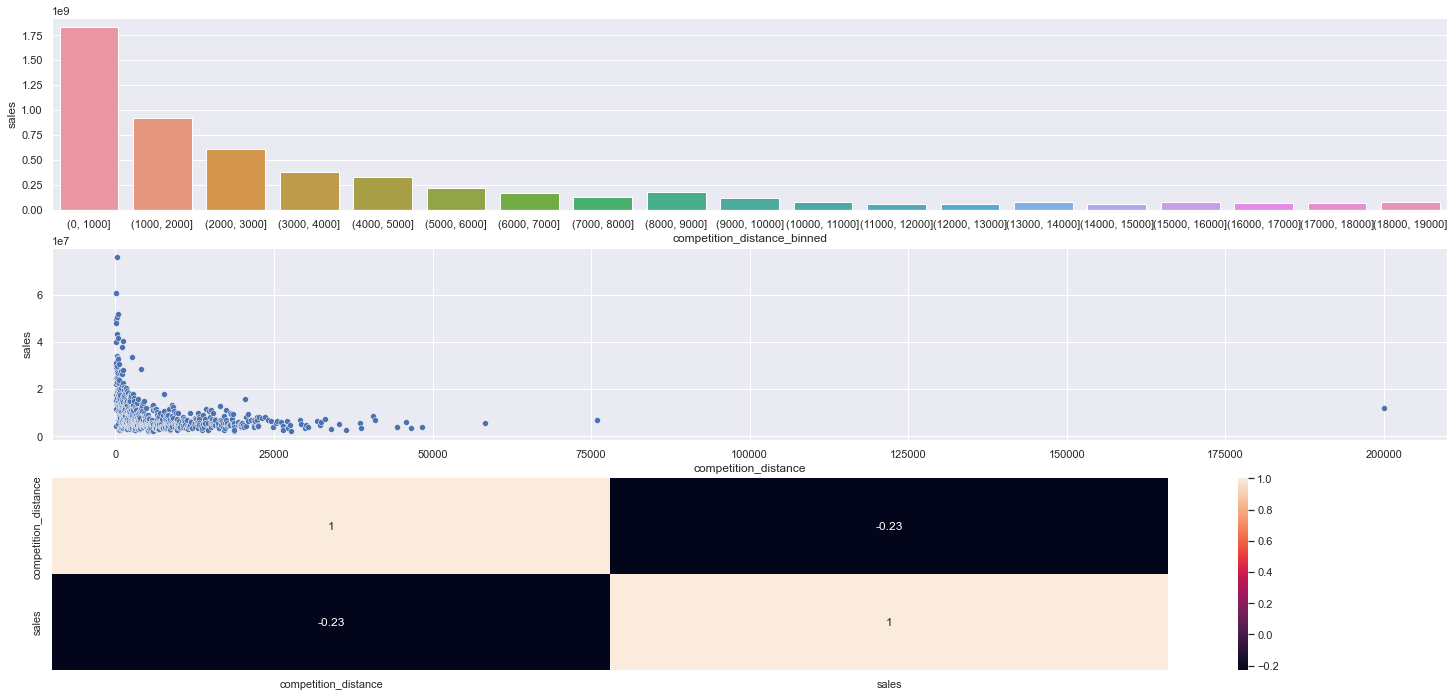

In [33]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(3,1,1)
sns.barplot(data = aux2, x='competition_distance_binned', y = 'sales');
plt.subplot(3,1,2)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);
plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

#### **H3.** Lojas com competidores há mais tempo deveriam vender mais.

***Falsa*** - Lojas com competidores há mais tempo vendenm **MENOS**.

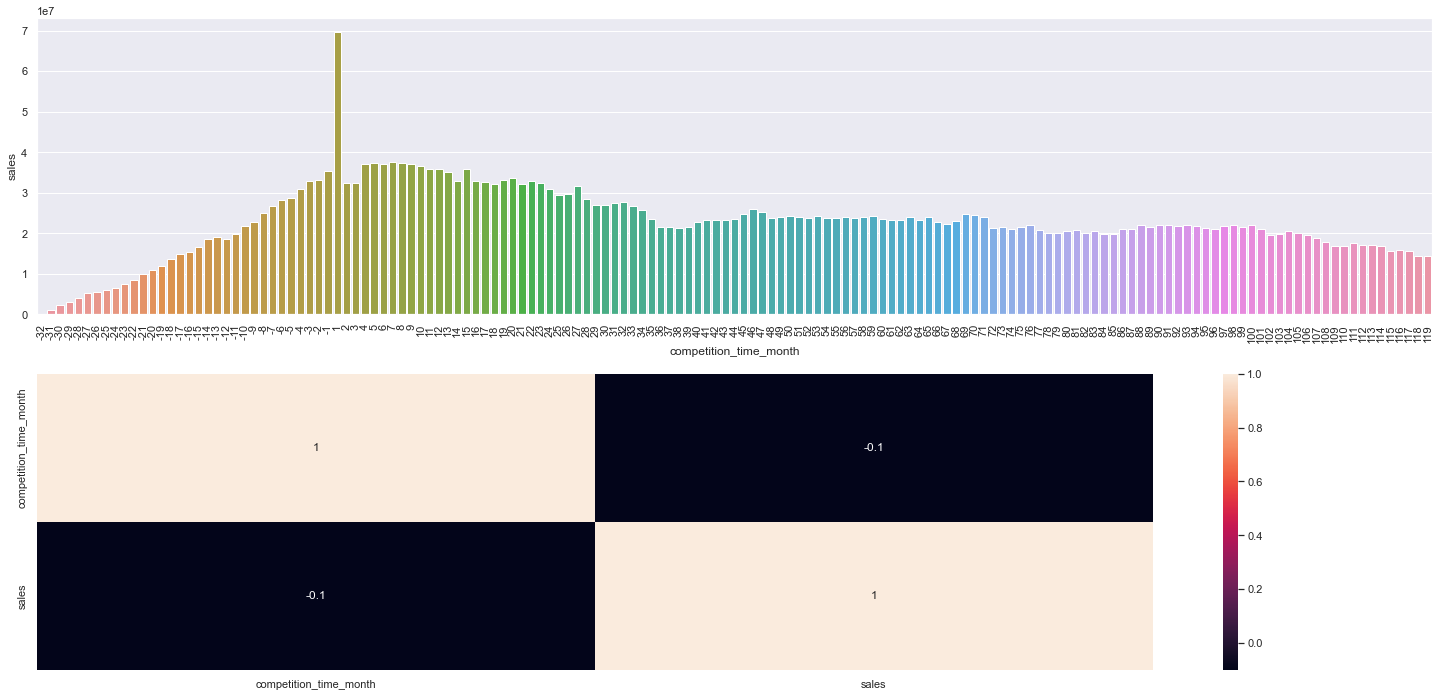

In [34]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120)& (aux1['competition_time_month'] != 0)]
plt.subplot(2,1,1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.subplot(2,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

***Falsa*** - Lojas com promoções ativas por mais tempo vendem **MENOS**, depois de um certo período de tempo.

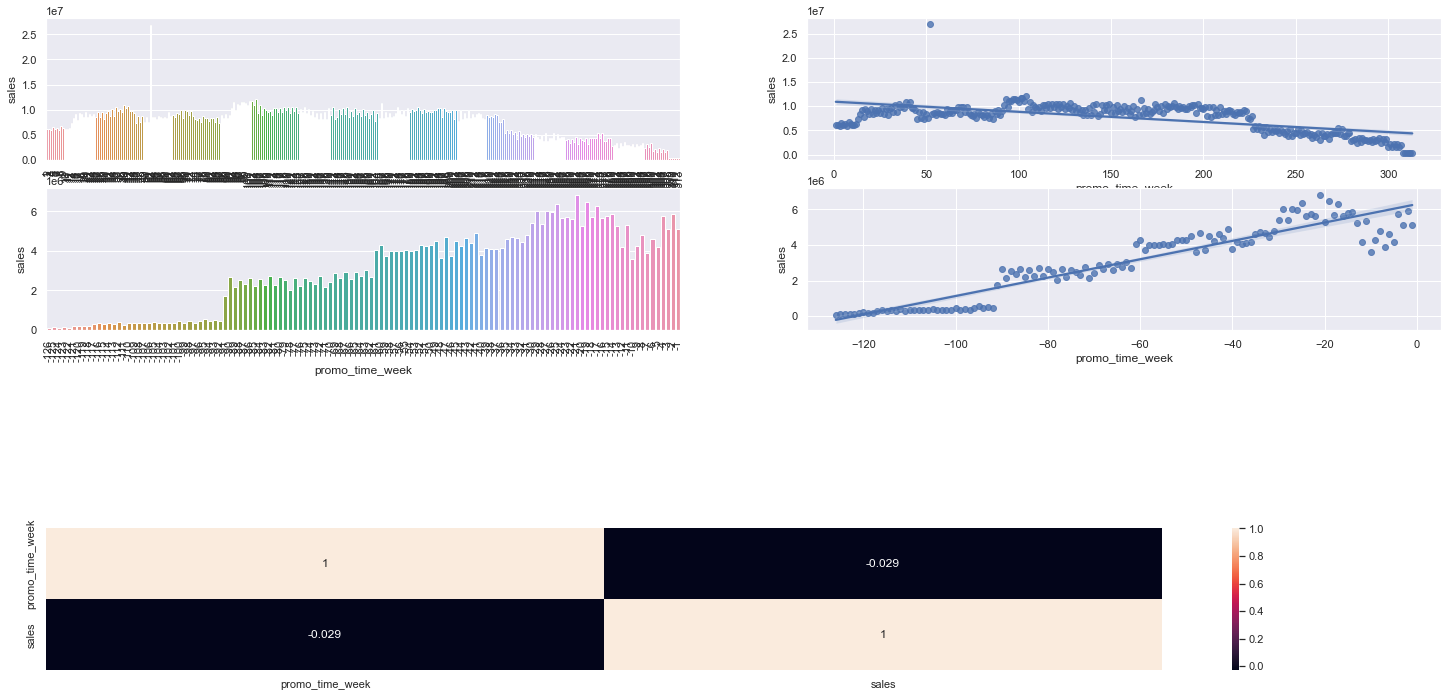

In [37]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec(4,2)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0]
sns.barplot(x = 'promo_time_week', y='sales',data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week',y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] <0]
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[3,:])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

***Falsa*** - Lojas com mais promoções consecutivas vendem **MENOS**.

In [38]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


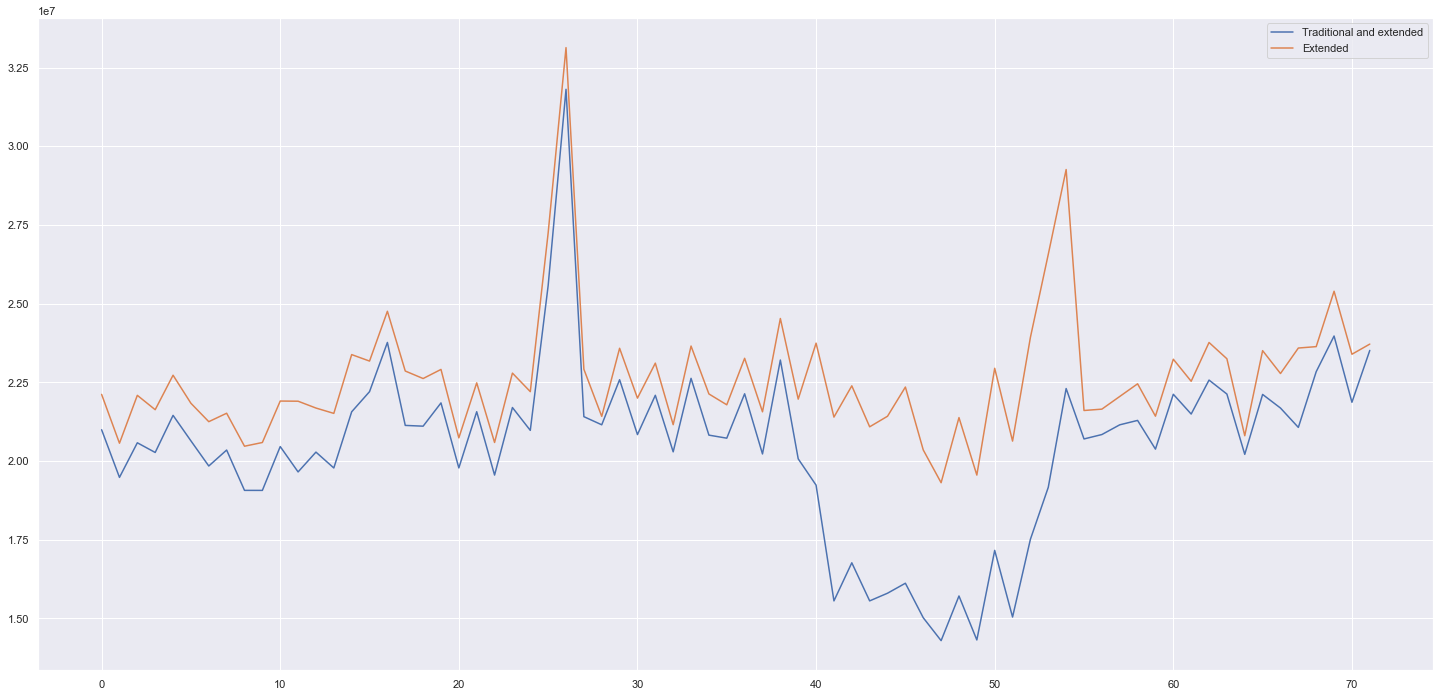

In [39]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Traditional and extended', 'Extended']);

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

***Falsa*** - Na verdade vendem **MENOS**.

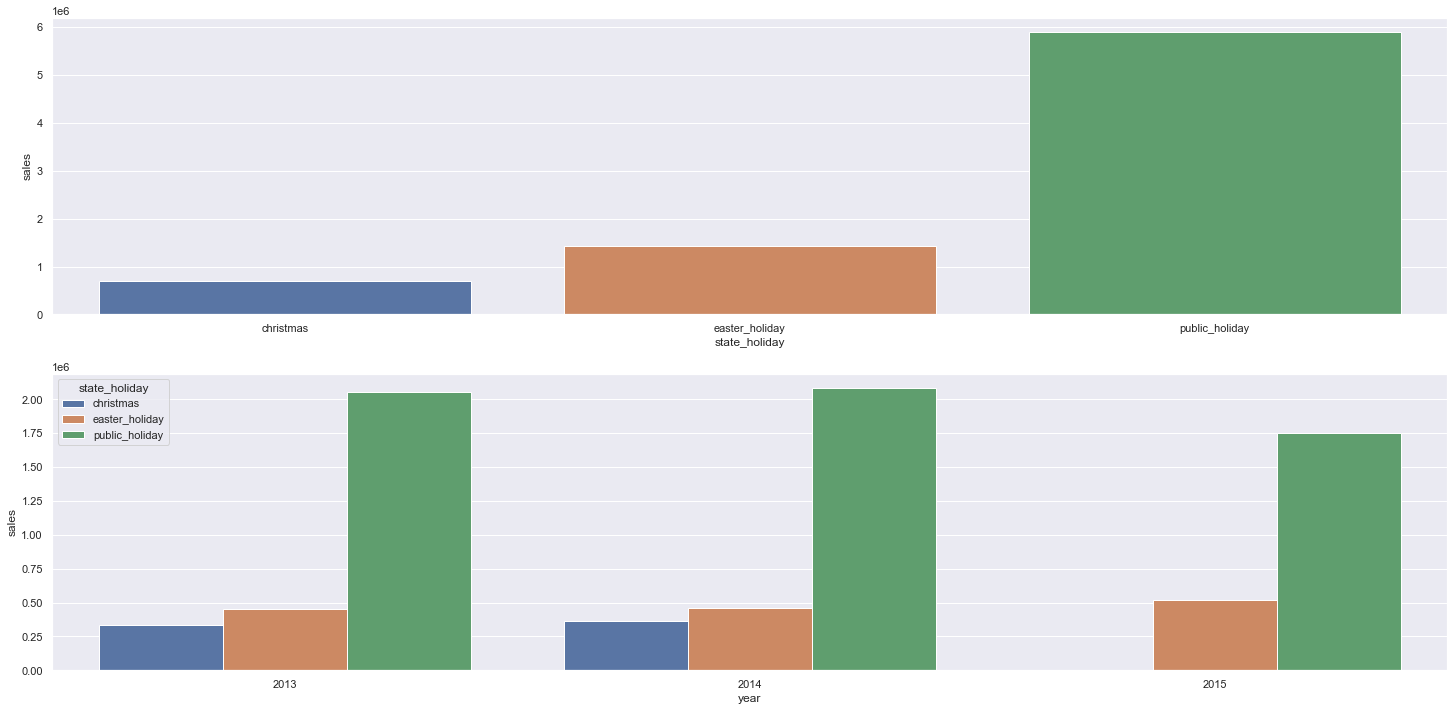

In [40]:
aux = df4[df4['state_holiday']!='regular_day']

plt.subplot(2,1,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data = aux1);

plt.subplot(2,1,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

#### **H8.** Lojas deveriam vender mais ao longo dos anos.

***Falso*** - Lojas vendem **MENOS** ao longo dos anos.

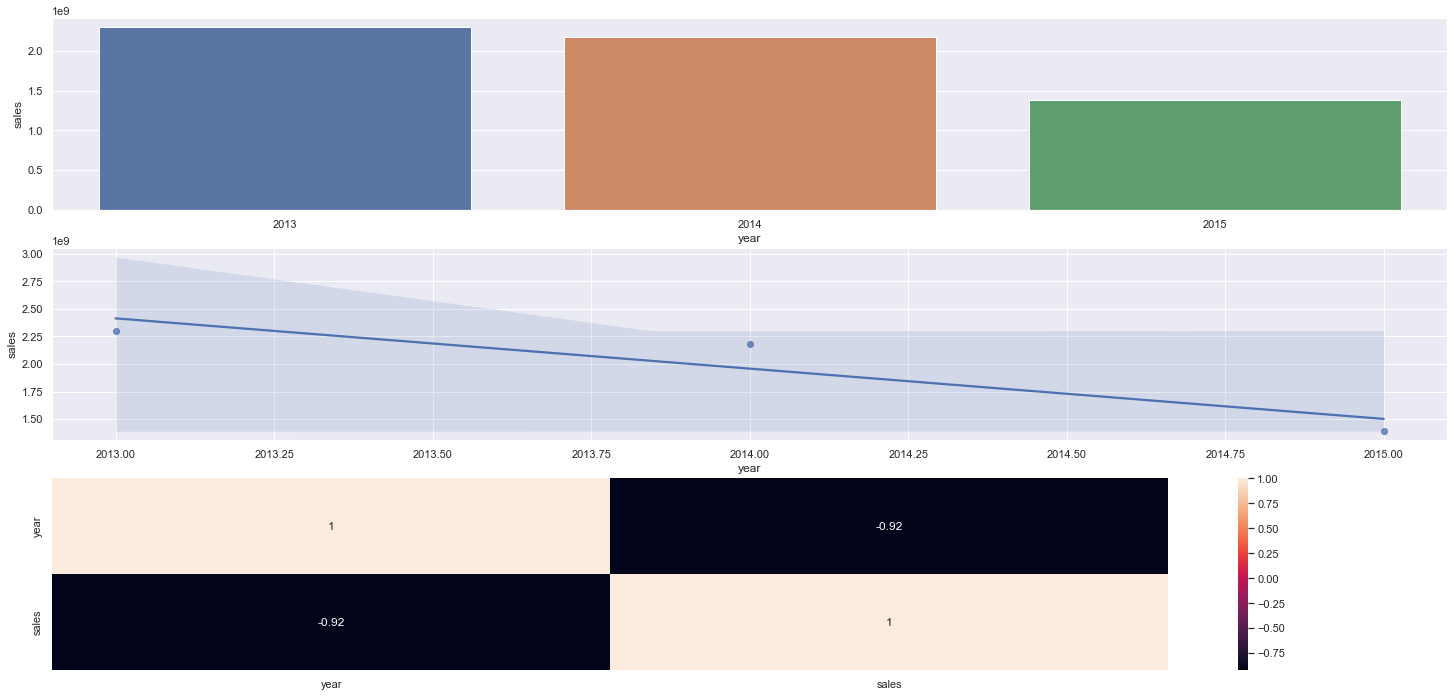

In [41]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(3,1,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(3,1,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

#### **H9.** Lojas deveriam vender menos no segundo semestre do ano.

***Falso*** - Na verdade as lojas vendem mais no **PRIMEIRO** semestre do ano.

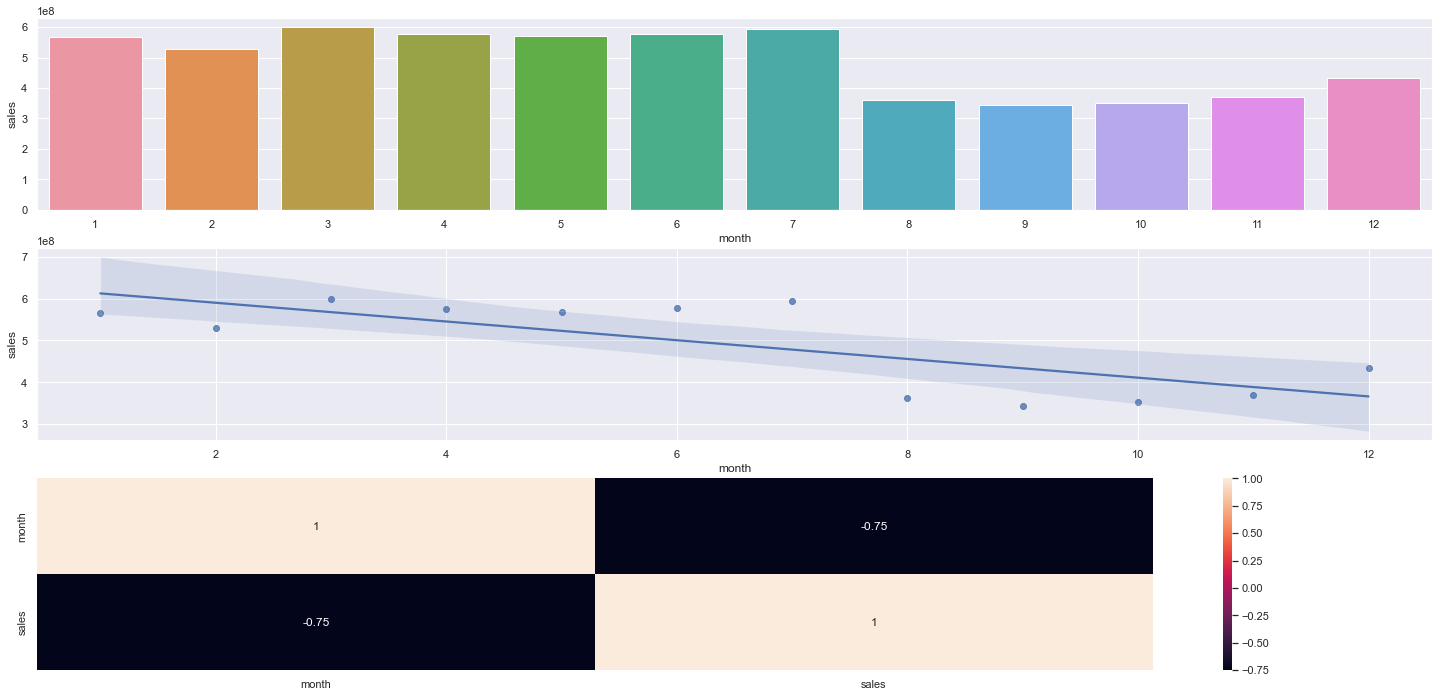

In [42]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(3,1,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(3,1,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

***Verdadeiro*** - Lojas vendem **MAIS** depois do dia 10 de cada mês.

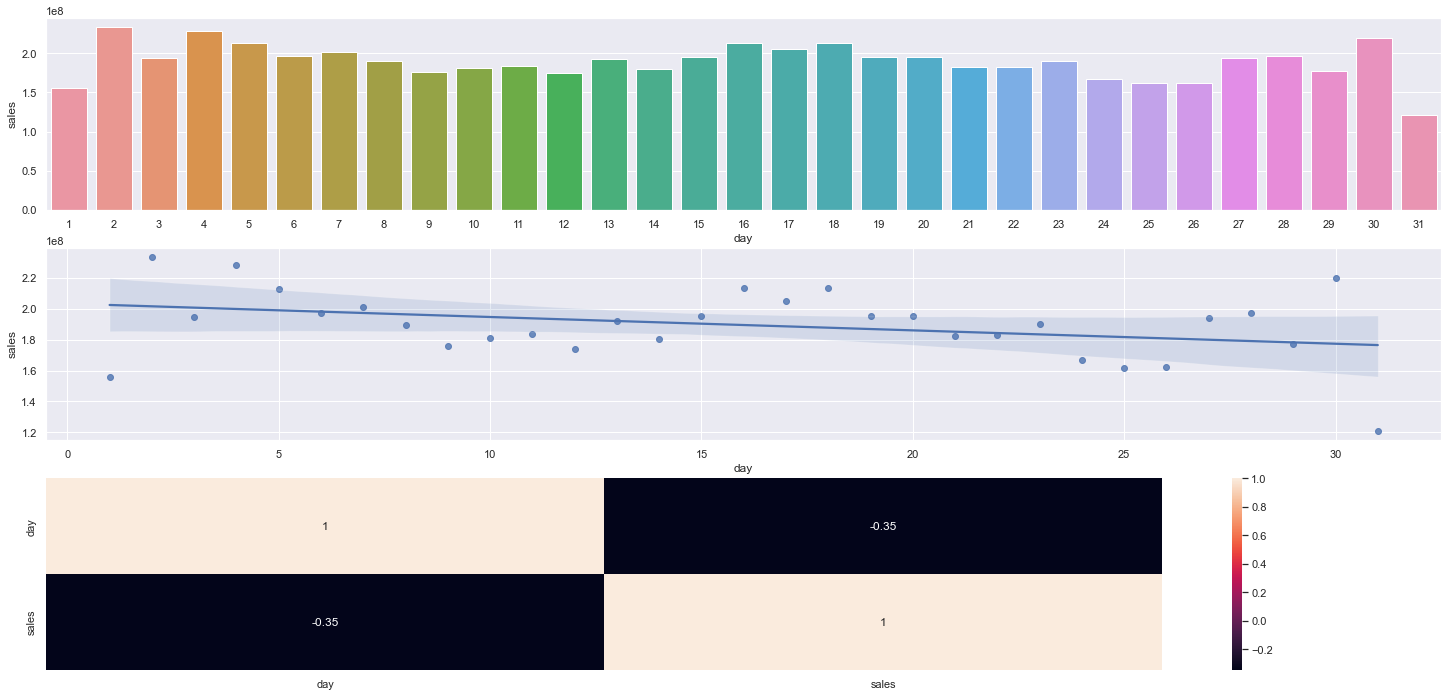

In [43]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(3,1,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(3,1,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

#### **H11.** Lojas deveriam vender menos aos finais de semana.

***Verdadeiro*** - Lojas vendem **MENOS** aos finais de semana.

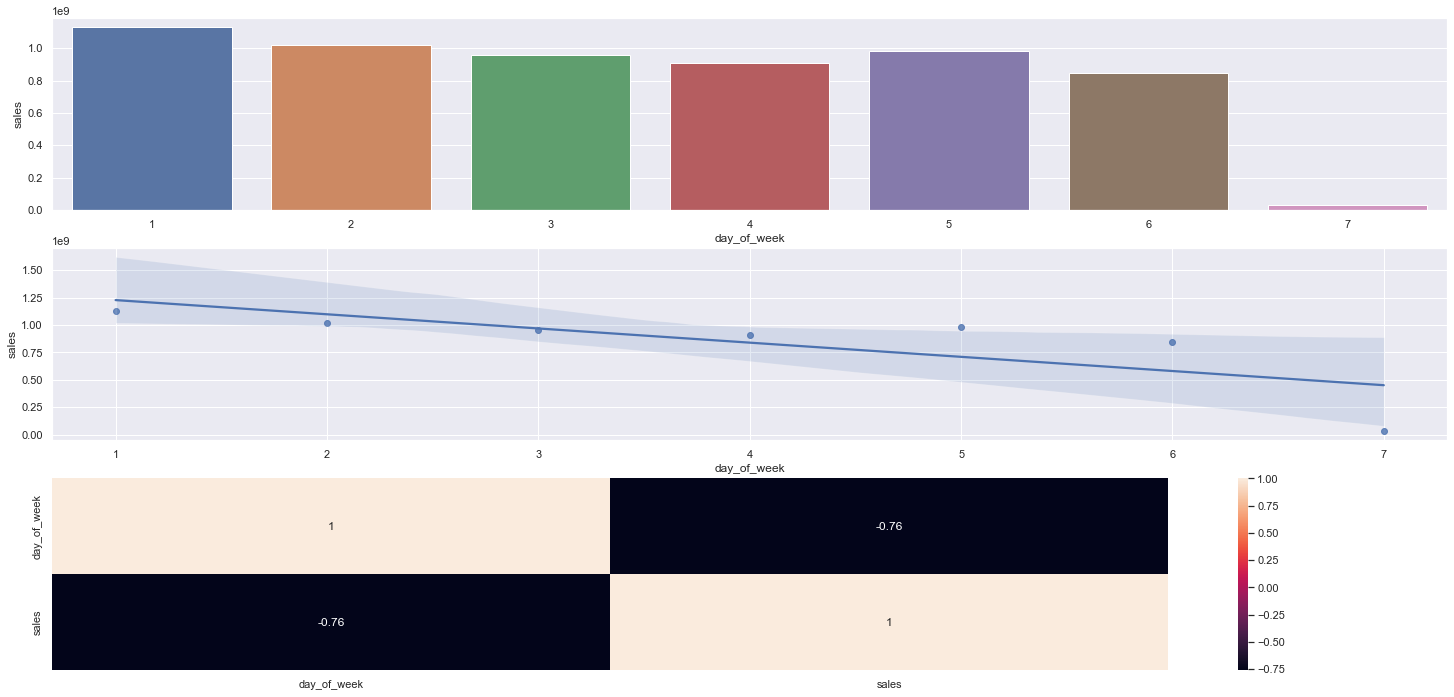

In [44]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(3,1,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(3,1,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

***Verdadeiro*** Lojas vendem **MENOS** durante os feriados escolares com **EXCEÇÃO DE JULHO E AGOSTO**.

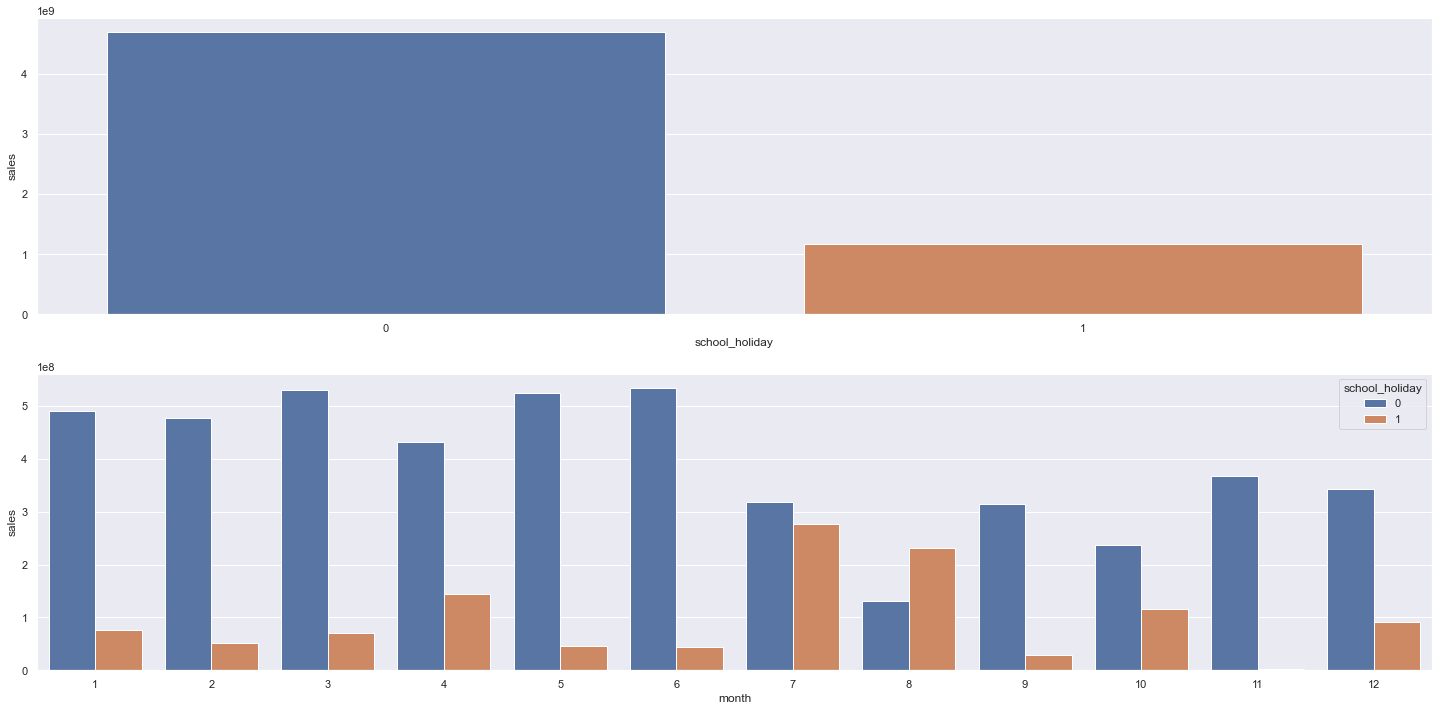

In [45]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

### Multivatiate Analysis

#### Numerical Attributes

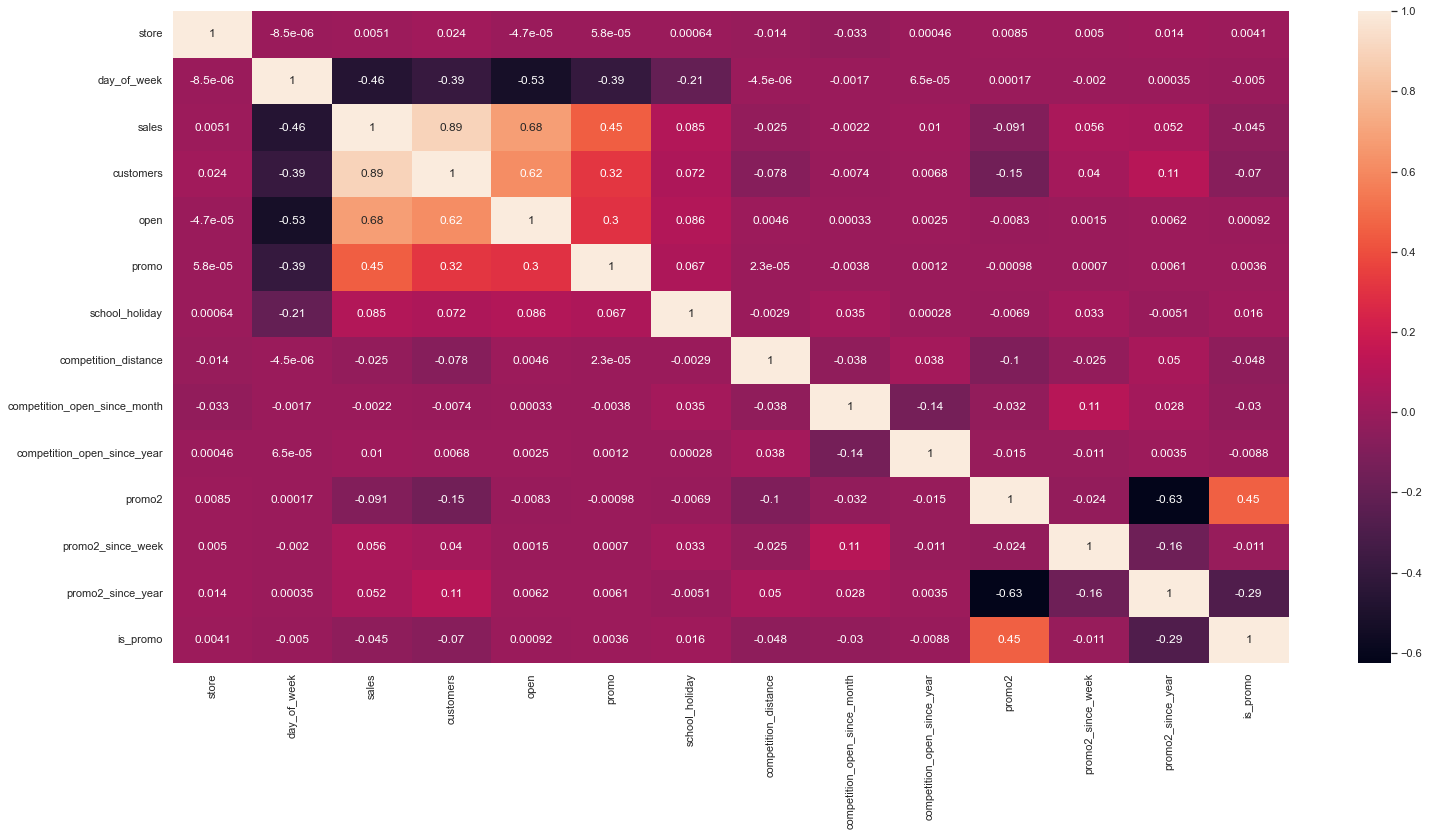

In [46]:
correlation = df_n.corr(method='pearson')
sns.heatmap(correlation,annot=True);

#### Categorical Attributes

In [47]:
df_c = df4.select_dtypes(include = 'object')

<AxesSubplot:>

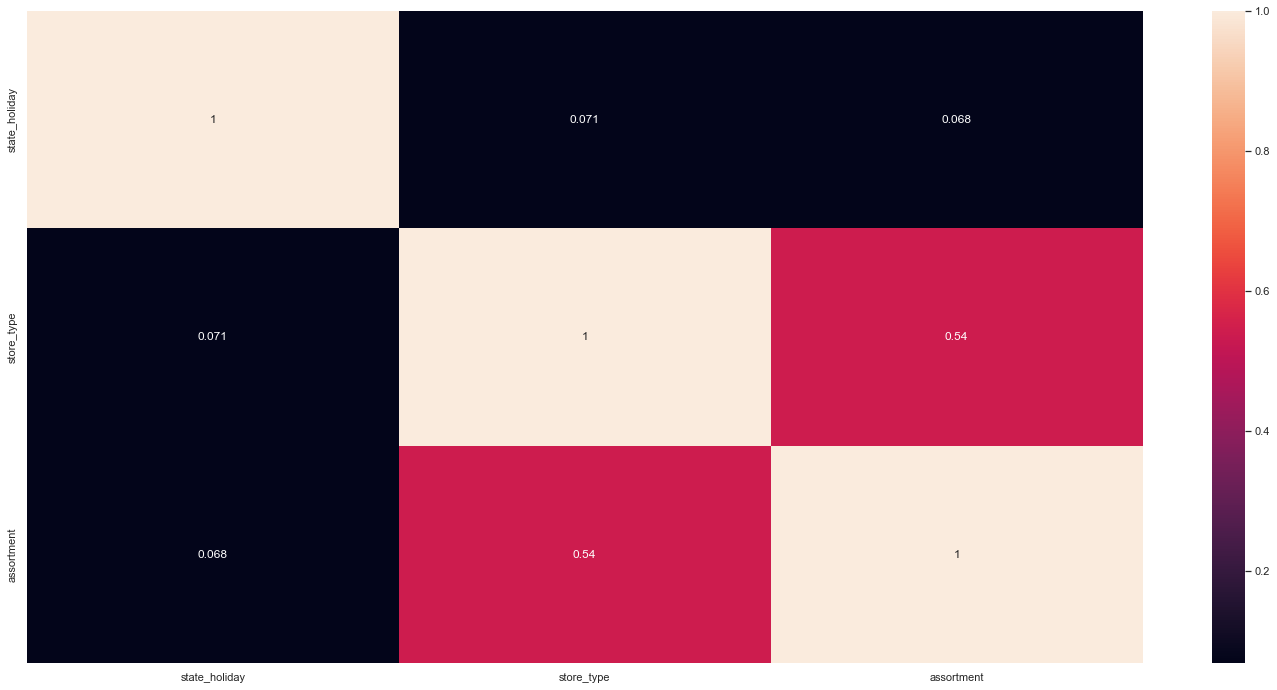

In [48]:
a1 = cramer_v(df_c['state_holiday'],df_c['state_holiday'])
a2 = cramer_v(df_c['state_holiday'],df_c['store_type'])
a3 = cramer_v(df_c['state_holiday'],df_c['assortment'])

a4 = cramer_v(df_c['store_type'],df_c['state_holiday'])
a5 = cramer_v(df_c['store_type'],df_c['store_type'])
a6 = cramer_v(df_c['store_type'],df_c['assortment'])

a7 = cramer_v(df_c['assortment'],df_c['state_holiday'])
a8 = cramer_v(df_c['assortment'],df_c['store_type'])
a9 = cramer_v(df_c['assortment'],df_c['assortment'])

d = pd.DataFrame({
                'state_holiday': [a1,a2,a3],
                'store_type': [a4,a5,a6],
                'assortment': [a7,a8,a9]
})

d = d.set_index(d.columns)
sns.heatmap(d,annot = True)

## Data Preparation

In [27]:
df5 = df4.copy()

### Normalization

Nenhum dado será normalizado pois nenhum apresenta comportamento de distribuição normal

### Rescaling

In [32]:
# competition distance
df5['competition_distance'] = RobustScaler().fit_transform(df5[['competition_distance']].values)
pickle.dump(RobustScaler(),open('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = RobustScaler().fit_transform(df5[['competition_time_month']].values)
pickle.dump(RobustScaler(),open('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = MinMaxScaler().fit_transform(df5[['promo_time_week']].values)
pickle.dump(MinMaxScaler(),open('parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = MinMaxScaler().fit_transform(df5[['year']].values)
pickle.dump(MinMaxScaler(),open('parameter/year_scaler.pkl','wb'))

### Transformation

#### Enconding

In [31]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

# store_type - Label Encoder
df5['store_type'] = LabelEncoder().fit_transform(df5['store_type'])
pickle.dump(LabelEncoder(),open('parameter/store_type_scaler.pkl','wb'))

# assortment - Ordinal Encoder
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### Response variable transformation

In [52]:
df5['sales'] = np.log1p(df5['sales'])

#### Nature transformation

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

## Feature Selection

In [54]:
df6 = df5.copy()

In [55]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

In [56]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

### Split Dataframe into training and test

In [57]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

### Boruta as Feature selector

In [53]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date','sales'],axis = 1).values
Y_train_n = Y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta =  BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### Best Features from Boruta

In [55]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date','sales'],axis = 1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.tolist()

# not selected features
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

In [56]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [57]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

### Manual Feature selection

In [58]:
cols_selected_boruta = [ 'store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_sin',
                         'month_cos',
                         'day_sin',
                         'day_cos',
                         'week_of_year_sin',
                         'week_of_year_cos' ]

# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## Machine Learning Modelling

In [59]:
x_train = X_train[cols_selected_boruta] 
x_test = X_test[cols_selected_boruta] 

### Training Models

#### Average Model

In [87]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# predictions
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average model', np.expm1(Y_test),np.expm1(yhat_baseline))
baseline_result

,Model name:,MAE:,MAPE:,RMSE:
0,Average model,1354.800353,0.455051,1835.135542


#### Linear Regression Model

In [88]:
# model
lr = LinearRegression().fit(x_train,Y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model name:,MAE:,MAPE:,RMSE:
0,Linear Regression,1867.089774,0.292694,2671.049215


#### Linear Regression Regularized Model - Lasso

In [91]:
# model
lrr = Lasso(alpha = 0.01).fit(x_train,Y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model name:,MAE:,MAPE:,RMSE:
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### Random Forest Regressor

In [94]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=42).fit(x_train,Y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model name:,MAE:,MAPE:,RMSE:
0,Random Forest Regressor,679.080548,0.099879,1010.101738


#### XGBoost Regressor

In [103]:
# model
model_xgb = xgb.XGBRegressor().fit(x_train,Y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model name:,MAE:,MAPE:,RMSE:
0,XGBoost Regressor,868.958204,0.130309,1238.550842


### Compare Model's Performances

In [106]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE:')

,Model name:,MAE:,MAPE:,RMSE:
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XGBoost Regressor,868.958204,0.130309,1238.550842
0,Average model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### Cross Validation

In [71]:
x_training = X_train[cols_selected_boruta_full]

#### Linear Regression Model

In [115]:
lr_result_cv = cross_validation(x_training,5,'Linear Regression',LinearRegression(),verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


#### Linear Regression Regularized Model - Lasso

In [116]:
lrr_result_cv = cross_validation(x_training,5,'Lasso',Lasso(alpha=0.01),verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


#### Random Forest Regressor

In [117]:
rf_result_cv = cross_validation(x_training,5,'Random Forest Regressor',RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=42),verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


#### XGBoost Regressor

In [121]:
xgb_result_cv = cross_validation(x_training,5,'XGBoost Regressor',xgb.XGBRegressor(),verbose=False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


### Compare Model's Performances - CV

In [122]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


XGBoost will be used as model to be applied

## Hyperparameter Fine Tuning

### Random Search

In [78]:
param = {
    'n_estimators' : [1500,1700,2500,3000,3500],
    'eta': [0.01,0.03],
    'max_depth':[3,5,9],
    'subsample':[0.1,0.5,0.7],
    'colsample_bytree': [0.3,0.7,0.9],
    'min_child_weight': [3,8,15]
}

MAX_EVAL = 5

In [79]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):

    # choose values for parameters randomly
    hp = {k: random.sample(v,1)[0] for k,v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])


    #performance
    result = cross_validation(x_training,2,'XGBoost Regressor',model_xgb, verbose = False)
    final_result = pd.concat([final_result,result])
    
final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1252.62 +/- 55.78,0.17 +/- 0.0,1820.02 +/- 100.14
0,XGBoost Regressor,1594.01 +/- 55.35,0.21 +/- 0.0,2318.73 +/- 102.1
0,XGBoost Regressor,1735.69 +/- 51.11,0.24 +/- 0.0,2514.41 +/- 95.36
0,XGBoost Regressor,861.64 +/- 77.5,0.12 +/- 0.01,1257.16 +/- 143.14
0,XGBoost Regressor,871.2 +/- 90.02,0.12 +/- 0.01,1261.29 +/- 154.09


### Final Model

In [80]:
param_tuned = {
    'n_estimators' : 2500,
    'eta': 0.01,
    'max_depth': 9,
    'subsample':0.7,
    'colsample_bytree': 0.9,
    'min_child_weight': 15
}

In [85]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = param_tuned['n_estimators'],
                                eta = param_tuned['eta'],
                                max_depth = param_tuned['max_depth'],
                                subsample = param_tuned['subsample'],
                                colsample_bytree = param_tuned['colsample_bytree'],
                                min_child_weight = param_tuned['min_child_weight']).fit(x_train,Y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [86]:
# performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(Y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,695.812204,0.101551,1021.820064


### Saving Model

In [98]:
pickle.dump(model_xgb_tuned, open('/home/pedro/Documentos/Curso_DS/Ciclo Preparação/Data Science em Produção/model_rossman.pkl','wb'))

## Error translation and interpretation

In [99]:
df9 = X_test[cols_selected_boruta_full].copy()

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### Business Performance

In [101]:
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92 = pd.merge(df91,df9_aux3,how='inner',on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [102]:
df92.sort_values('MAPE',ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106637.359375,103216.475123,110058.243627,3420.884252,0.583417
908,909,226021.906250,218228.265328,233815.547172,7793.640922,0.517627
594,595,332008.687500,326678.840979,337338.534021,5329.846521,0.365387
875,876,200238.156250,196282.962020,204193.350480,3955.194230,0.301414
434,435,138477.218750,137719.852143,139234.585357,757.366607,0.266799


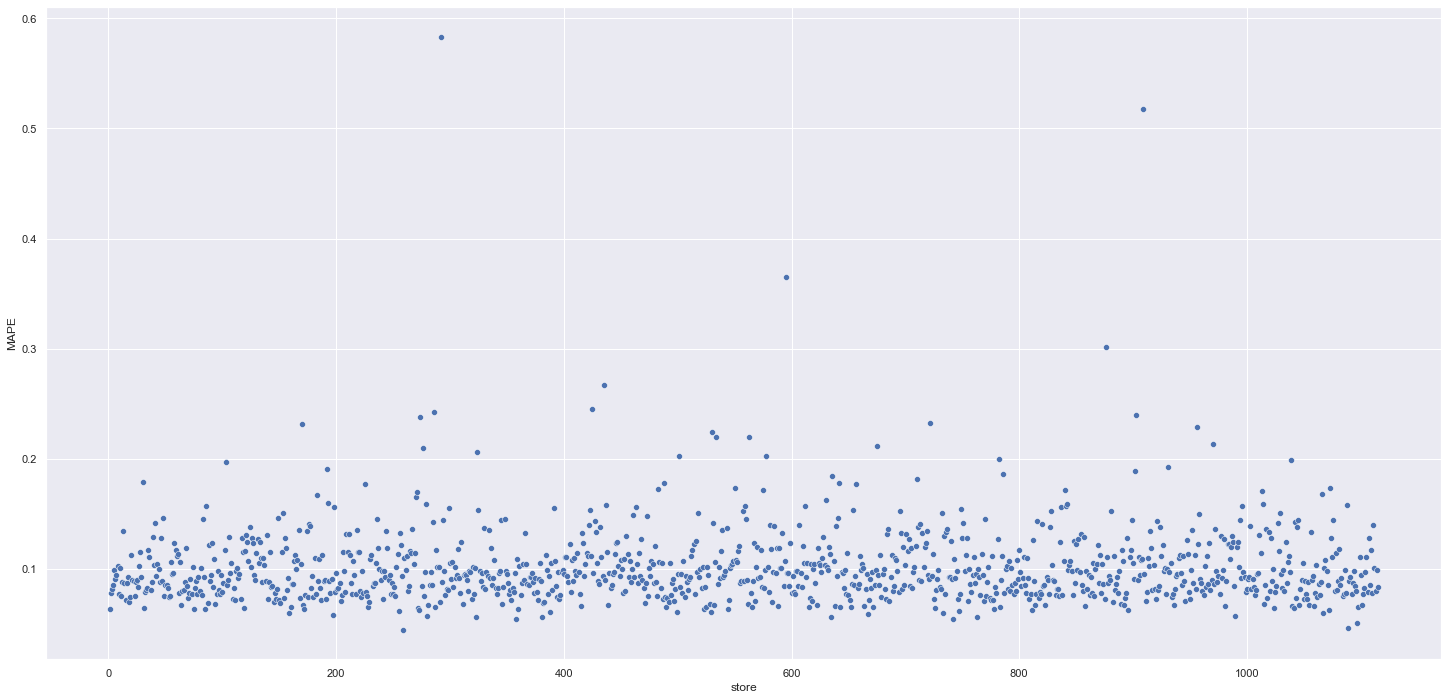

In [104]:
sns.scatterplot(x='store',y='MAPE',data=df92);

### Total Performance

In [105]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index':'Scenario',0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$283,174,464.00"
1,worst_scenario,"R$282,395,178.47"
2,best_scenario,"R$283,953,791.34"


### Machine Learning Performance

In [106]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/pedro/anaconda3/envs/ross.sales/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


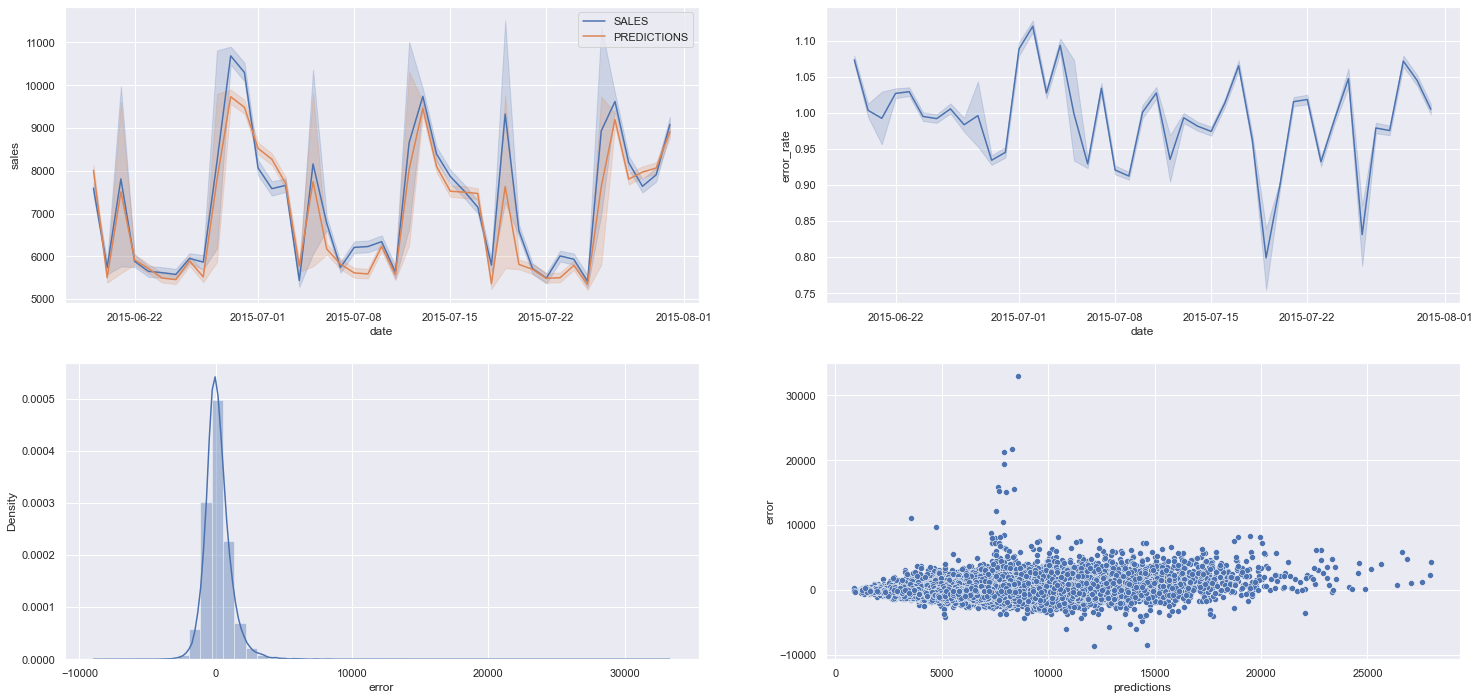

In [111]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES');
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data = df9);

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);